## Project 3

Dataset: COMPAS

In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

In [276]:
df = pd.read_csv("compas-scores-two-years.csv")
print(df['decile_score'])
print(df.columns)

0       1
1       3
2       4
3       8
4       1
       ..
7209    7
7210    3
7211    1
7212    2
7213    4
Name: decile_score, Length: 7214, dtype: int64
Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody'

We will first fit a model predicting if the person will reoffend in the next two years. We could use a classifier for this.

Next steps:

* look at the data for bias
* build a classifier

Sensitive variables: race, sex

Target variable: two_year_recid

Features: age/age_cat, juv_fel_count, juv_misd_count, juv_other_count, priors_count, c_charge_degree, score_text, days_b_screening_arrest, decile_score, length_of_stay

## Twin test

Feature: prior convictions

In [278]:
df = df[(df['race']=='African-American') | (df['race']=='Caucasian')]

In [275]:
sampled_african_american = df[df['race'] == 'African-American'].sample(n=2454, random_state=42)
sampled_caucasian = df[df['race'] == 'Caucasian'].sample(n=2454, random_state=42)

# Combine the samples into one dataset
df = pd.concat([sampled_african_american, sampled_caucasian])


In [279]:
df

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
6,8,edward riddle,edward,riddle,2014-02-19,Male,1974-07-23,41,25 - 45,Caucasian,...,2,Low,2014-02-19,2014-03-31,2014-04-18,14,5,40,1,1
8,10,elizabeth thieme,elizabeth,thieme,2014-03-16,Female,1976-06-03,39,25 - 45,Caucasian,...,1,Low,2014-03-16,2014-03-15,2014-03-18,0,2,747,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7207,10994,jarred payne,jarred,payne,2014-05-10,Male,1985-07-31,30,25 - 45,African-American,...,2,Low,2014-05-10,2015-10-22,2015-10-22,0,0,529,1,1
7208,10995,raheem smith,raheem,smith,2013-10-20,Male,1995-06-28,20,Less than 25,African-American,...,9,High,2013-10-20,2014-04-07,2014-04-27,0,0,169,0,0
7209,10996,steven butler,steven,butler,2013-11-23,Male,1992-07-17,23,Less than 25,African-American,...,5,Medium,2013-11-23,2013-11-22,2013-11-24,0,1,860,0,0
7210,10997,malcolm simmons,malcolm,simmons,2014-02-01,Male,1993-03-25,23,Less than 25,African-American,...,5,Medium,2014-02-01,2014-01-31,2014-02-02,0,1,790,0,0


In [280]:
df['sex'].unique()

array(['Male', 'Female'], dtype=object)

In [281]:
#df = df[["race", "sex", "age_cat", "juv_fel_count", "juv_misd_count", "juv_other_count", "priors_count", "c_charge_degree", "two_year_recid"]]

df = df[["race", "age_cat", 'v_score_text', 'decile_score', "two_year_recid"]]

#df = df[(df["c_charge_degree"] != 'O')]

# sum 1-20 together
#df["juv_fel_count"] = np.where(df["juv_fel_count"] == 0, 0, 1)
#df["juv_misd_count"] = np.where(df["juv_misd_count"] == 0, 0, 1)
#df["juv_other_count"] = np.where(df["juv_other_count"] == 0, 0, 1)
#df["priors_count"]

#df.loc[(df['priors_count'] >= 0) & (df['priors_count'] <= 10), 'priors_count'] = 0
#df.loc[(df['priors_count'] > 10) & (df['priors_count'] <= 20), 'priors_count'] = 1
#df.loc[(df['priors_count'] > 20), 'priors_count'] = 2

#df["sex"] = np.where(df["sex"] == "Male", 0, 1)
df["age_cat"] = df["age_cat"].replace({"Less than 25": 0, "25 - 45": 1, "Greater than 45": 2})
df["v_score_text"] = df["v_score_text"].replace({"Low": 0, "Medium": 1, "High": 2})
df["race"] = df["race"].replace({"Asian": "Minority", "Native American": "Minority", "Other": "Minority"})
print(df["race"].unique())
df["sensitive"] =df["race"]

df.head()
df.to_csv("data_clean.csv")

['African-American' 'Caucasian']


<ipython-input-281-ec071387a5de>:18: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

<ipython-input-281-ec071387a5de>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-281-ec071387a5de>:19: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

<ipython-input-281-ec071387a5de>:19: Settin

In [282]:
import pandas as pd

def individual_fairness(df, charge_column,outcome_column):
    """
    Compute probabilities for individual fairness based on the sensitive attribute and a specified charge column.

    Parameters
    ----------
    file_path : str
        Path to the CSV file containing the data.
    charge_column : str
        The column name corresponding to the charge degree.

    Returns
    -------
    pd.DataFrame
        A DataFrame with computed probabilities for individual fairness analysis.
    """
    # Read the dataset
    # Group by sensitive attribute, charge degree, and recidivism outcome
    df_count = df.groupby(["sensitive", charge_column, outcome_column]).agg(
        count=('sensitive', 'count')).reset_index()

    # Sum counts for each sensitive attribute and charge degree
    df_sum = df_count.groupby(["sensitive", charge_column]).agg(
        sum=('count', 'sum')).reset_index()

    # Merge the count and sum dataframes
    df_summary = pd.merge(df_count, df_sum, on=["sensitive", charge_column])

    # Calculate probabilities
    df_summary["prob"] = df_summary["count"] / df_summary["sum"]
    print(outcome_column)
    df_summary = df_summary[df_summary[outcome_column]==1]
    # Print the summary
    print(df_summary)

    return df_summary

In [283]:
# Call the function with the appropriate file path and charge column
df = pd.read_csv('data_clean.csv')

#data_summary = individual_fairness(df, "c_charge_degree", 'two_year_recid')
data_summary = individual_fairness(df, "age_cat", 'two_year_recid')
#df_summary = individual_fairness(df, "age_cat" , 'two_year_recid')
#df_summary = individual_fairness(df, "juv_fel_count" , 'two_year_recid')
#df_summary = individual_fairness(df, "c_charge_degree", 'two_year_recid')
#df_summary = individual_fairness(df, "juv_other_count", 'two_year_recid')


two_year_recid
           sensitive  age_cat  two_year_recid  count   sum      prob
1   African-American        0               1    561   920  0.609783
3   African-American        1               1   1110  2194  0.505925
5   African-American        2               1    230   582  0.395189
7          Caucasian        0               1    191   390  0.489744
9          Caucasian        1               1    566  1312  0.431402
11         Caucasian        2               1    209   752  0.277926


In [284]:
df

,Unnamed: 0,race,age_cat,v_score_text,decile_score,two_year_recid,sensitive
0,1,African-American,1,0,3,1,African-American
1,2,African-American,0,0,4,1,African-American
2,3,African-American,0,1,8,0,African-American
3,6,Caucasian,1,0,6,1,Caucasian
4,8,Caucasian,1,0,1,0,Caucasian
...,...,...,...,...,...,...,...
6145,7207,African-American,1,0,2,1,African-American
6146,7208,African-American,0,2,9,0,African-American
6147,7209,African-American,0,1,7,0,African-American
6148,7210,African-American,0,1,3,0,African-American


## Model

In [285]:
df = pd.read_csv("data_clean.csv")

# Select relevant columns for features and target
features = df.iloc[:, 2:-2]
print(features)
target = df['two_year_recid']

# Handle missing values if any
features = features.fillna(0)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train a logistic regression model
model = LogisticRegression(max_iter=1000)
model = RandomForestClassifier(n_estimators=100, random_state=42)
# Train an XGBoost model (replacing Logistic Regression)
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

#model.fit(X_train, y_train)

# Make predictions
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_test_pred)
report = classification_report(y_test, y_test_pred)
print(report)

      age_cat  v_score_text  decile_score
0           1             0             3
1           0             0             4
2           0             1             8
3           1             0             6
4           1             0             1
...       ...           ...           ...
6145        1             0             2
6146        0             2             9
6147        0             1             7
6148        0             1             3
6149        1             0             2

[6150 rows x 3 columns]
              precision    recall  f1-score   support

           0       0.66      0.74      0.70       652
           1       0.66      0.58      0.62       578

    accuracy                           0.66      1230
   macro avg       0.66      0.66      0.66      1230
weighted avg       0.66      0.66      0.66      1230



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning:

[14:10:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




In [315]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Load cleaned data
df = pd.read_csv("data_clean.csv")

# Step 1: Compute probabilities using Naive Bayes
def compute_probabilities_with_naive_bayes(df, features, target):
    """
    Compute probabilities of positive outcomes for each instance using a Naive Bayes model.

    Parameters
    ----------
    df : pd.DataFrame
        The dataset.
    features : list
        The list of feature columns.
    target : str
        The target label column.

    Returns
    -------
    pd.Series
        The probabilities of positive outcomes.
    """
    # Train-Test split
    X = df[features]
    y = df[target]

    # Handle missing values
    X = X.fillna(0)

    # Train a Naive Bayes model
    naive_bayes = GaussianNB()
    naive_bayes.fit(X, y)

    # Predict probabilities of positive outcomes
    probabilities = naive_bayes.predict_proba(X)[:, 1]
    return probabilities

# Step 2: Apply Massaging
def massage_data(df, sensitive_column, target_column, probabilities, alpha=0.8):
    """
    Massage the dataset based on computed probabilities to make p(+|F) ~ p(+|M).

    Parameters
    ----------
    df : pd.DataFrame
        The dataset to massage.
    sensitive_column : str
        The sensitive attribute column.
    target_column : str
        The target label column.
    probabilities : pd.Series
        Probabilities of positive outcomes from Naive Bayes.
    alpha : float
        The threshold for massaging based on probabilities.

    Returns
    -------
    pd.DataFrame
        The massaged dataset with adjusted target labels.
    """
    df["probability"] = probabilities

    # Group by sensitive attribute and calculate propensity scores
    propensity_scores = df.groupby(sensitive_column)[target_column].mean()
    disadvantaged_group = propensity_scores.idxmin()
    advantaged_group = propensity_scores.idxmax()

    print(f"Disadvantaged group: {disadvantaged_group}, Advantaged group: {advantaged_group}")

    # Split into groups
    disadvantaged_data = df[df[sensitive_column] == disadvantaged_group]
    advantaged_data = df[df[sensitive_column] == advantaged_group]

    # Sort by probabilities to identify label changes
    disadvantaged_sorted = disadvantaged_data.sort_values(by="probability", ascending=False)
    advantaged_sorted = advantaged_data.sort_values(by="probability", ascending=True)

    # Determine the number of labels to change based on the gap
    target_gap = propensity_scores[advantaged_group] - propensity_scores[disadvantaged_group]
    num_to_change = int(target_gap * len(disadvantaged_data) * alpha)  # Adjust with alpha

    print(f"Number of labels to change: {num_to_change}")

    # Change labels for disadvantaged group (- to +)
    change_positive_indices = disadvantaged_sorted.iloc[:num_to_change].index
    df.loc[change_positive_indices, target_column] = 1

    # Change labels for advantaged group (+ to -)
    change_negative_indices = advantaged_sorted.iloc[:num_to_change].index
    df.loc[change_negative_indices, target_column] = 0

    df = df.drop(columns=["probability"])  # Remove helper column
    return df

# Step 3: Apply Preferential Resampling
def preferential_resampling(df, sensitive_column, target_column, probabilities, alpha=0.5):
    """
    Perform preferential resampling to adjust class distribution for fairness.

    Parameters
    ----------
    df : pd.DataFrame
        The dataset to resample.
    sensitive_column : str
        The sensitive attribute column.
    target_column : str
        The target label column.
    probabilities : pd.Series
        Probabilities of positive outcomes from Naive Bayes.
    alpha : float
        The resampling adjustment factor.

    Returns
    -------
    pd.DataFrame
        The resampled dataset.
    """
    df["probability"] = probabilities

    # Group by sensitive attribute and calculate propensity scores
    propensity_scores = df.groupby(sensitive_column)[target_column].mean()
    disadvantaged_group = propensity_scores.idxmin()
    advantaged_group = propensity_scores.idxmax()

    print(f"Disadvantaged group: {disadvantaged_group}, Advantaged group: {advantaged_group}")

    # Split into groups
    disadvantaged_data = df[df[sensitive_column] == disadvantaged_group]
    advantaged_data = df[df[sensitive_column] == advantaged_group]

    # Sort by probabilities
    disadvantaged_sorted = disadvantaged_data.sort_values(by="probability", ascending=False)
    advantaged_sorted = advantaged_data.sort_values(by="probability", ascending=True)

    # Determine the number of samples to duplicate/delete
    target_gap = propensity_scores[advantaged_group] - propensity_scores[disadvantaged_group]
    num_to_adjust = int(target_gap * len(disadvantaged_data) * alpha)

    print(f"Number of samples to adjust: {num_to_adjust}")

    # Duplicate disadvantaged instances
    duplicates = disadvantaged_sorted.iloc[:num_to_adjust]
    df = pd.concat([df, duplicates])

    # Delete advantaged instances
    delete_indices = advantaged_sorted.iloc[:num_to_adjust].index
    df = df.drop(delete_indices)

    df = df.drop(columns=["probability"])  # Remove helper column
    return df

# Step 4: Toggle between methods
def apply_fairness_methods(df, features, target, sensitive_column, apply_massaging=False, apply_resampling=True):
    """
    Apply massaging and/or preferential resampling to the dataset.

    Parameters
    ----------
    df : pd.DataFrame
        The dataset.
    features : list
        Feature columns.
    target : str
        Target label column.
    sensitive_column : str
        Sensitive attribute column.
    apply_massaging : bool
        Whether to apply massaging.
    apply_resampling : bool
        Whether to apply preferential resampling.

    Returns
    -------
    pd.DataFrame
        The transformed dataset.
    """
    probabilities = compute_probabilities_with_naive_bayes(df, features, target)

    if apply_massaging:
        print("Applying Massaging...")
        df = massage_data(df, sensitive_column, target, probabilities)

    if apply_resampling:
        print("Applying Preferential Resampling...")
        df = preferential_resampling(df, sensitive_column, target, probabilities)

    return df

# Define features and target
features = ["age_cat", "v_score_text", "decile_score"]
target = "two_year_recid"
sensitive_column = "sensitive"

# Apply fairness methods
df_fair = apply_fairness_methods(df, features, target, sensitive_column, apply_massaging=False, apply_resampling=True)

# Step 5: Train Logistic Regression on the adjusted dataset
X = df_fair[features]
y = df_fair[target]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

# Make predictions
y_test_pred = log_reg.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_test_pred)
report = classification_report(y_test, y_test_pred)

print("Accuracy after applying fairness methods:", accuracy)
print("Classification Report:\n", report)


Applying Preferential Resampling...
Disadvantaged group: Caucasian, Advantaged group: African-American
Number of samples to adjust: 148
Accuracy after applying fairness methods: 0.6593495934959349
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.71      0.69       665
           1       0.64      0.59      0.62       565

    accuracy                           0.66      1230
   macro avg       0.66      0.65      0.65      1230
weighted avg       0.66      0.66      0.66      1230



In [316]:
df_test = X_test.copy()
df_test['two_year_recid_actual'] = y_test
df_test['two_year_recid_predicted'] = y_test_pred
df_test["sensitive"] = df.loc[df_test.index.values, "sensitive"]
df_test["data_split"] = "test"

# Create a DataFrame for the training set
df_train = X_train.copy()
df_train['two_year_recid_actual'] = y_train
df_train['two_year_recid_predicted'] = y_train_pred
df_train["sensitive"] = df.loc[df_train.index.values, "sensitive"]
df_train["data_split"] = "train"

# Concatenate train and test results
all_results = pd.concat([df_train, df_test], ignore_index=True)

In [317]:
all_results

,age_cat,v_score_text,decile_score,two_year_recid_actual,two_year_recid_predicted,sensitive,data_split
0,2,1,7,1,0,African-American,train
1,1,0,4,0,0,African-American,train
2,1,1,7,1,0,African-American,train
3,2,0,6,1,0,Caucasian,train
4,0,1,4,0,1,Caucasian,train
...,...,...,...,...,...,...,...
6145,1,0,5,1,0,African-American,test
6146,1,1,6,1,1,African-American,test
6147,1,0,3,0,0,African-American,test
6148,1,1,5,1,0,African-American,test


In [318]:
model_summary = individual_fairness(all_results, "age_cat", 'two_year_recid_predicted')

two_year_recid_predicted
           sensitive  age_cat  two_year_recid_predicted  count   sum      prob
1   African-American        0                         1    468   920  0.508696
3   African-American        1                         1    951  2194  0.433455
5   African-American        2                         1    177   434  0.407834
7          Caucasian        0                         1    222   466  0.476395
9          Caucasian        1                         1    533  1381  0.385952
11         Caucasian        2                         1    276   755  0.365563


In [319]:
import pandas as pd
import plotly.express as px

def plot_probabilities_plotly(model_summary, data_summary, sensitive_columns, prob_columns):
    """
    Function to plot probabilities using Plotly, grouped by sensitive columns.

    Parameters:
    - model_summary: DataFrame containing model-specific summaries.
    - data_summary: DataFrame containing data-specific summaries.
    - sensitive_columns: List of column names that are sensitive (e.g., gender, race).
    - prob_columns: List of columns that represent probabilities (e.g., prob1, prob2).
    """
    # Add a 'Type' column to distinguish model and data summaries
    model_summary['Type'] = 'Model'
    data_summary['Type'] = 'Data'

    # Combine both dataframes into one
    combined_df = pd.concat([model_summary, data_summary])

    # Melt the dataframe to get a long-form table
    melted_df = combined_df.melt(id_vars=sensitive_columns + ['Type'], value_vars=prob_columns,
                                 var_name='Probability', value_name='Value')
    print(melted_df)
    # Create an interactive bar plot using Plotly Express
    fig = px.bar(melted_df, x='Probability', y='Value', color='Type',
                 barmode='group', facet_col='sensitive',  # You can adjust facets based on other columns
                 title="Probabilities by Sensitive Columns and Model/Data Type",
                 labels={'Value': 'Probability'},
                 category_orders={'Probability': prob_columns})  # Preserve the order of prob columns

    # Show the plot
    fig.update_layout(yaxis_title="Probability")
    fig.show()
# Example usage:
# Let's assume `model_summary` and `data_summary` are your dataframes


## Analyse v_score_text

In [246]:
df_model = model_summary[model_summary['v_score_text']==0]
df_data = data_summary[data_summary['v_score_text']==0]
#df_model = age_cat
#df_data = data_summary

sensitive_columns = ['sensitive']
prob_columns = ['prob']

# You can call the function as follows:
plot_probabilities_plotly(df_model, df_data, sensitive_columns, prob_columns)


          sensitive   Type Probability     Value
0  African-American  Model        prob  0.250490
1         Caucasian  Model        prob  0.143380
2  African-American   Data        prob  0.410784
3         Caucasian   Data        prob  0.342229


<ipython-input-245-417b62dae8ec>:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-245-417b62dae8ec>:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [247]:
df_model = model_summary[model_summary['v_score_text']==1]
df_data = data_summary[data_summary['v_score_text']==1]
#df_model = age_cat
#df_data = data_summary

sensitive_columns = ['sensitive']
prob_columns = ['prob']

# You can call the function as follows:
plot_probabilities_plotly(df_model, df_data, sensitive_columns, prob_columns)


          sensitive   Type Probability     Value
0  African-American  Model        prob  0.790036
1         Caucasian  Model        prob  0.684086
2  African-American   Data        prob  0.596975
3         Caucasian   Data        prob  0.546318


<ipython-input-245-417b62dae8ec>:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-245-417b62dae8ec>:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [206]:
df_model = model_summary[model_summary['v_score_text']==0]
df_data = data_summary[data_summary['v_score_text']==0]
#df_model = age_cat
#df_data = data_summary

sensitive_columns = ['sensitive']
prob_columns = ['prob']

# You can call the function as follows:
plot_probabilities_plotly(df_model, df_data, sensitive_columns, prob_columns)


          sensitive   Type Probability     Value
0  African-American  Model        prob  0.250490
1         Caucasian  Model        prob  0.143380
2  African-American   Data        prob  0.410784
3         Caucasian   Data        prob  0.342229


<ipython-input-205-417b62dae8ec>:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-205-417b62dae8ec>:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [253]:
df_model = model_summary[model_summary['v_score_text']==1]
df_data = data_summary[data_summary['v_score_text']==1]
#df_model = age_cat
#df_data = data_summary

sensitive_columns = ['sensitive']
prob_columns = ['prob']

# You can call the function as follows:
plot_probabilities_plotly(df_model, df_data, sensitive_columns, prob_columns)


          sensitive   Type Probability     Value
0  African-American  Model        prob  0.786477
1         Caucasian  Model        prob  0.674584
2  African-American   Data        prob  0.596975
3         Caucasian   Data        prob  0.546318


<ipython-input-252-417b62dae8ec>:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-252-417b62dae8ec>:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [213]:
df_model = model_summary[model_summary['v_score_text']==0]
df_data = data_summary[data_summary['v_score_text']==0]
#df_model = age_cat
#df_data = data_summary

sensitive_columns = ['sensitive']
prob_columns = ['prob']

# You can call the function as follows:
plot_probabilities_plotly(df_model, df_data, sensitive_columns, prob_columns)


<ipython-input-212-417b62dae8ec>:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-212-417b62dae8ec>:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



          sensitive   Type Probability     Value
0  African-American  Model        prob  0.400634
1         Caucasian  Model        prob  0.365777
2  African-American   Data        prob  0.410784
3         Caucasian   Data        prob  0.342229


In [215]:
df_model = model_summary[model_summary['v_score_text']==1]
df_data = data_summary[data_summary['v_score_text']==1]
#df_model = age_cat
#df_data = data_summary

sensitive_columns = ['sensitive']
prob_columns = ['prob']

# You can call the function as follows:
plot_probabilities_plotly(df_model, df_data, sensitive_columns, prob_columns)


          sensitive   Type Probability     Value
0  African-American  Model        prob  0.489324
1         Caucasian  Model        prob  0.465324
2  African-American   Data        prob  0.596975
3         Caucasian   Data        prob  0.546318


<ipython-input-212-417b62dae8ec>:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-212-417b62dae8ec>:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [220]:
df_model = model_summary[model_summary['v_score_text']==0]
df_data = data_summary[data_summary['v_score_text']==0]
#df_model = age_cat
#df_data = data_summary

sensitive_columns = ['sensitive']
prob_columns = ['prob']

# You can call the function as follows:
plot_probabilities_plotly(df_model, df_data, sensitive_columns, prob_columns)


          sensitive   Type Probability     Value
0  African-American  Model        prob  0.382760
1         Caucasian  Model        prob  0.357405
2  African-American   Data        prob  0.410784
3         Caucasian   Data        prob  0.342229


<ipython-input-212-417b62dae8ec>:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-212-417b62dae8ec>:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [221]:
 df_model = model_summary[model_summary['v_score_text']==1]
df_data = data_summary[data_summary['v_score_text']==1]
#df_model = age_cat
#df_data = data_summary

sensitive_columns = ['sensitive']
prob_columns = ['prob']

# You can call the function as follows:
plot_probabilities_plotly(df_model, df_data, sensitive_columns, prob_columns)


          sensitive   Type Probability     Value
0  African-American  Model        prob  0.499110
1         Caucasian  Model        prob  0.465558
2  African-American   Data        prob  0.596975
3         Caucasian   Data        prob  0.546318


<ipython-input-212-417b62dae8ec>:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-212-417b62dae8ec>:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [233]:
df_model = model_summary[model_summary['v_score_text']==0]
df_data = data_summary[data_summary['v_score_text']==0]
#df_model = age_cat
#df_data = data_summary

sensitive_columns = ['sensitive']
prob_columns = ['prob']

# You can call the function as follows:
plot_probabilities_plotly(df_model, df_data, sensitive_columns, prob_columns)


<ipython-input-232-417b62dae8ec>:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-232-417b62dae8ec>:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



          sensitive   Type Probability     Value
0  African-American  Model        prob  0.246078
1         Caucasian  Model        prob  0.141811
2  African-American   Data        prob  0.410784
3         Caucasian   Data        prob  0.342229


In [234]:
df_model = model_summary[model_summary['v_score_text']==1]
df_data = data_summary[data_summary['v_score_text']==1]
#df_model = age_cat
#df_data = data_summary

sensitive_columns = ['sensitive']
prob_columns = ['prob']

# You can call the function as follows:
plot_probabilities_plotly(df_model, df_data, sensitive_columns, prob_columns)


          sensitive   Type Probability     Value
0  African-American  Model        prob  0.788256
1         Caucasian  Model        prob  0.674584
2  African-American   Data        prob  0.596975
3         Caucasian   Data        prob  0.546318


<ipython-input-232-417b62dae8ec>:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-232-417b62dae8ec>:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



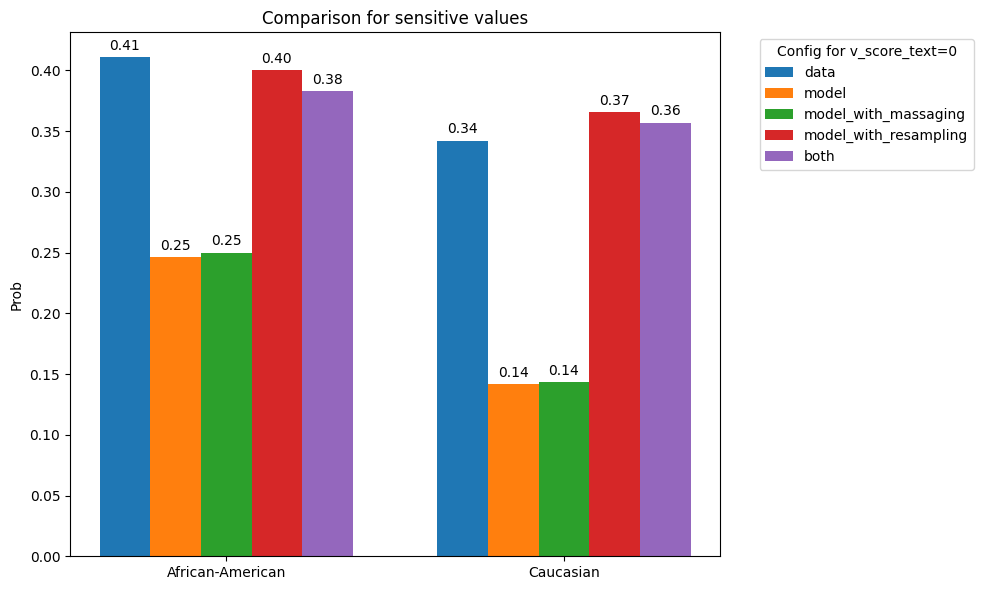

In [329]:
import matplotlib.pyplot as plt
import numpy as np

# Data
tasks = ['African-American', 'Caucasian']
categories = ['data', 'model', 'model_with_massaging', 'model_with_resampling', 'both']
values = {
    'African-American': [0.4107, 0.2460, 0.25, 0.40, 0.3827],
    'Caucasian': [0.3422, 0.1418, 0.1433, 0.3657, 0.357]
}

# Plot settings
x = np.arange(len(tasks))  # label locations for tasks
width = 0.15  # bar width for each category

fig, ax = plt.subplots(figsize=(10, 6))

# Create bars for each category and task
for i, category in enumerate(categories):
    offsets = x + (i - 2) * width  # offsets for bars within each task group
    ax.bar(offsets, [values[task][i] for task in tasks], width, label=category)

# Add labels, title, and legend
ax.set_ylabel('Prob')
ax.set_title('Comparison for sensitive values')
ax.set_xticks(x)
ax.set_xticklabels(tasks)
ax.legend(title="Config for v_score_text=0", bbox_to_anchor=(1.05, 1), loc='upper left')

# Annotate bars
for i, category in enumerate(categories):
    offsets = x + (i - 2) * width
    for j, offset in enumerate(offsets):
        value = values[tasks[j]][i]
        ax.annotate(f'{value:.2f}',
                    xy=(offset, value),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()


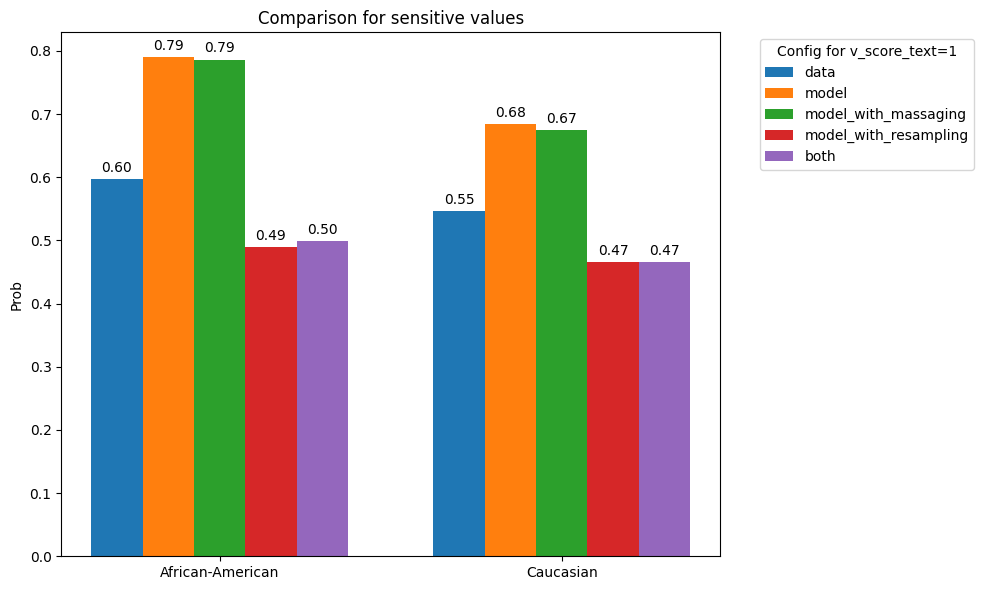

In [330]:
import matplotlib.pyplot as plt
import numpy as np

# Data
tasks = ['African-American', 'Caucasian']
categories = ['data', 'model', 'model_with_massaging', 'model_with_resampling', 'both']
values = {
    'African-American': [0.596975, 0.790036, 0.786477, 0.489324, 0.499110],
    'Caucasian': [0.546318, 0.684086, 0.674584, 0.465324, 0.465558]
}
# Plot settings
x = np.arange(len(tasks))  # label locations for tasks
width = 0.15  # bar width for each category

fig, ax = plt.subplots(figsize=(10, 6))

# Create bars for each category and task
for i, category in enumerate(categories):
    offsets = x + (i - 2) * width  # offsets for bars within each task group
    ax.bar(offsets, [values[task][i] for task in tasks], width, label=category)

# Add labels, title, and legend
ax.set_ylabel('Prob')
ax.set_title('Comparison for sensitive values')
ax.set_xticks(x)
ax.set_xticklabels(tasks)
ax.legend(title="Config for v_score_text=1", bbox_to_anchor=(1.05, 1), loc='upper left')

# Annotate bars
for i, category in enumerate(categories):
    offsets = x + (i - 2) * width
    for j, offset in enumerate(offsets):
        value = values[tasks[j]][i]
        ax.annotate(f'{value:.2f}',
                    xy=(offset, value),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()


## Analyse age_cat

In [290]:
df_model = model_summary[model_summary['age_cat']==0]
df_data = data_summary[data_summary['age_cat']==0]
#df_model = age_cat
#df_data = data_summary

sensitive_columns = ['sensitive']
prob_columns = ['prob']

# You can call the function as follows:
plot_probabilities_plotly(df_model, df_data, sensitive_columns, prob_columns)

df_model = model_summary[model_summary['age_cat']==1]
df_data = data_summary[data_summary['age_cat']==1]
#df_model = age_cat
#df_data = data_summary

sensitive_columns = ['sensitive']
prob_columns = ['prob']

# You can call the function as follows:
plot_probabilities_plotly(df_model, df_data, sensitive_columns, prob_columns)

df_model = model_summary[model_summary['age_cat']==2]
df_data = data_summary[data_summary['age_cat']==2]
#df_model = age_cat
#df_data = data_summary

sensitive_columns = ['sensitive']
prob_columns = ['prob']

# You can call the function as follows:
plot_probabilities_plotly(df_model, df_data, sensitive_columns, prob_columns)



          sensitive   Type Probability     Value
0  African-American  Model        prob  0.691304
1         Caucasian  Model        prob  0.600000
2  African-American   Data        prob  0.609783
3         Caucasian   Data        prob  0.489744


<ipython-input-289-417b62dae8ec>:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-289-417b62dae8ec>:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



          sensitive   Type Probability     Value
0  African-American  Model        prob  0.499088
1         Caucasian  Model        prob  0.282012
2  African-American   Data        prob  0.505925
3         Caucasian   Data        prob  0.431402


<ipython-input-289-417b62dae8ec>:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-289-417b62dae8ec>:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<ipython-input-289-417b62dae8ec>:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-289-417b62dae8ec>:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



          sensitive   Type Probability     Value
0  African-American  Model        prob  0.321306
1         Caucasian  Model        prob  0.106383
2  African-American   Data        prob  0.395189
3         Caucasian   Data        prob  0.277926


In [295]:
df_model = model_summary[model_summary['age_cat']==0]
df_data = data_summary[data_summary['age_cat']==0]
#df_model = age_cat
#df_data = data_summary

sensitive_columns = ['sensitive']
prob_columns = ['prob']

# You can call the function as follows:
plot_probabilities_plotly(df_model, df_data, sensitive_columns, prob_columns)

df_model = model_summary[model_summary['age_cat']==1]
df_data = data_summary[data_summary['age_cat']==1]
#df_model = age_cat
#df_data = data_summary

sensitive_columns = ['sensitive']
prob_columns = ['prob']

# You can call the function as follows:
plot_probabilities_plotly(df_model, df_data, sensitive_columns, prob_columns)

df_model = model_summary[model_summary['age_cat']==2]
df_data = data_summary[data_summary['age_cat']==2]
#df_model = age_cat
#df_data = data_summary

sensitive_columns = ['sensitive']
prob_columns = ['prob']

# You can call the function as follows:
plot_probabilities_plotly(df_model, df_data, sensitive_columns, prob_columns)



          sensitive   Type Probability     Value
0  African-American  Model        prob  0.693478
1         Caucasian  Model        prob  0.602564
2  African-American   Data        prob  0.609783
3         Caucasian   Data        prob  0.489744


<ipython-input-289-417b62dae8ec>:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-289-417b62dae8ec>:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<ipython-input-289-417b62dae8ec>:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-289-417b62dae8ec>:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



          sensitive   Type Probability     Value
0  African-American  Model        prob  0.496809
1         Caucasian  Model        prob  0.279726
2  African-American   Data        prob  0.505925
3         Caucasian   Data        prob  0.431402


<ipython-input-289-417b62dae8ec>:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-289-417b62dae8ec>:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



          sensitive   Type Probability     Value
0  African-American  Model        prob  0.309278
1         Caucasian  Model        prob  0.099734
2  African-American   Data        prob  0.395189
3         Caucasian   Data        prob  0.277926


In [320]:
df_model = model_summary[model_summary['age_cat']==0]
df_data = data_summary[data_summary['age_cat']==0]
#df_model = age_cat
#df_data = data_summary

sensitive_columns = ['sensitive']
prob_columns = ['prob']

# You can call the function as follows:
plot_probabilities_plotly(df_model, df_data, sensitive_columns, prob_columns)

df_model = model_summary[model_summary['age_cat']==1]
df_data = data_summary[data_summary['age_cat']==1]
#df_model = age_cat
#df_data = data_summary

sensitive_columns = ['sensitive']
prob_columns = ['prob']

# You can call the function as follows:
plot_probabilities_plotly(df_model, df_data, sensitive_columns, prob_columns)

df_model = model_summary[model_summary['age_cat']==2]
df_data = data_summary[data_summary['age_cat']==2]
#df_model = age_cat
#df_data = data_summary

sensitive_columns = ['sensitive']
prob_columns = ['prob']

# You can call the function as follows:
plot_probabilities_plotly(df_model, df_data, sensitive_columns, prob_columns)



          sensitive   Type Probability     Value
0  African-American  Model        prob  0.508696
1         Caucasian  Model        prob  0.476395
2  African-American   Data        prob  0.609783
3         Caucasian   Data        prob  0.489744


<ipython-input-319-417b62dae8ec>:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-319-417b62dae8ec>:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



          sensitive   Type Probability     Value
0  African-American  Model        prob  0.433455
1         Caucasian  Model        prob  0.385952
2  African-American   Data        prob  0.505925
3         Caucasian   Data        prob  0.431402


<ipython-input-319-417b62dae8ec>:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-319-417b62dae8ec>:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<ipython-input-319-417b62dae8ec>:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-319-417b62dae8ec>:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



          sensitive   Type Probability     Value
0  African-American  Model        prob  0.407834
1         Caucasian  Model        prob  0.365563
2  African-American   Data        prob  0.395189
3         Caucasian   Data        prob  0.277926


In [308]:
df_model = model_summary[model_summary['age_cat']==0]
df_data = data_summary[data_summary['age_cat']==0]
#df_model = age_cat
#df_data = data_summary

sensitive_columns = ['sensitive']
prob_columns = ['prob']

# You can call the function as follows:
plot_probabilities_plotly(df_model, df_data, sensitive_columns, prob_columns)

df_model = model_summary[model_summary['age_cat']==1]
df_data = data_summary[data_summary['age_cat']==1]
#df_model = age_cat
#df_data = data_summary

sensitive_columns = ['sensitive']
prob_columns = ['prob']

# You can call the function as follows:
plot_probabilities_plotly(df_model, df_data, sensitive_columns, prob_columns)

df_model = model_summary[model_summary['age_cat']==2]
df_data = data_summary[data_summary['age_cat']==2]
#df_model = age_cat
#df_data = data_summary

sensitive_columns = ['sensitive']
prob_columns = ['prob']

# You can call the function as follows:
plot_probabilities_plotly(df_model, df_data, sensitive_columns, prob_columns)



          sensitive   Type Probability     Value
0  African-American  Model        prob  0.488043
1         Caucasian  Model        prob  0.444444
2  African-American   Data        prob  0.609783
3         Caucasian   Data        prob  0.489744


<ipython-input-307-417b62dae8ec>:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-307-417b62dae8ec>:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<ipython-input-307-417b62dae8ec>:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-307-417b62dae8ec>:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



          sensitive   Type Probability     Value
0  African-American  Model        prob  0.440292
1         Caucasian  Model        prob  0.391272
2  African-American   Data        prob  0.505925
3         Caucasian   Data        prob  0.431402


<ipython-input-307-417b62dae8ec>:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-307-417b62dae8ec>:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



          sensitive   Type Probability     Value
0  African-American  Model        prob  0.378819
1         Caucasian  Model        prob  0.353723
2  African-American   Data        prob  0.395189
3         Caucasian   Data        prob  0.277926


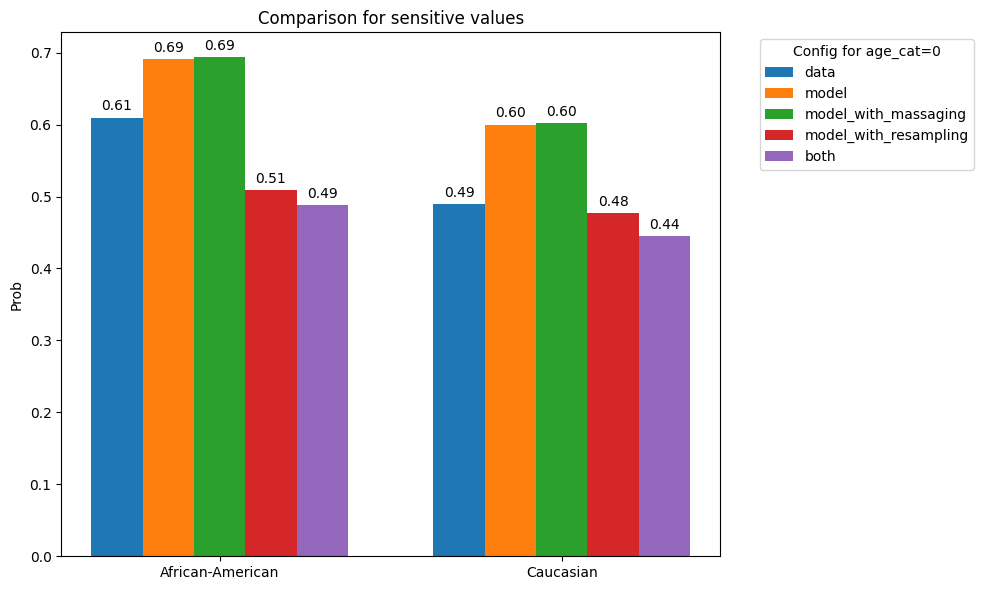

In [326]:
import matplotlib.pyplot as plt
import numpy as np

# Data
tasks = ['African-American', 'Caucasian']
categories = ['data', 'model', 'model_with_massaging', 'model_with_resampling', 'both']
values = {
    'African-American': [0.609783, 0.691304, 0.693478, 0.508696, 0.488043],
    'Caucasian': [0.489744, 0.600000, 0.602564, 0.476395, 0.444444]
}
# Plot settings
x = np.arange(len(tasks))  # label locations for tasks
width = 0.15  # bar width for each category

fig, ax = plt.subplots(figsize=(10, 6))

# Create bars for each category and task
for i, category in enumerate(categories):
    offsets = x + (i - 2) * width  # offsets for bars within each task group
    ax.bar(offsets, [values[task][i] for task in tasks], width, label=category)

# Add labels, title, and legend
ax.set_ylabel('Prob')
ax.set_title('Comparison for sensitive values')
ax.set_xticks(x)
ax.set_xticklabels(tasks)
ax.legend(title="Config for age_cat=0", bbox_to_anchor=(1.05, 1), loc='upper left')

# Annotate bars
for i, category in enumerate(categories):
    offsets = x + (i - 2) * width
    for j, offset in enumerate(offsets):
        value = values[tasks[j]][i]
        ax.annotate(f'{value:.2f}',
                    xy=(offset, value),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()


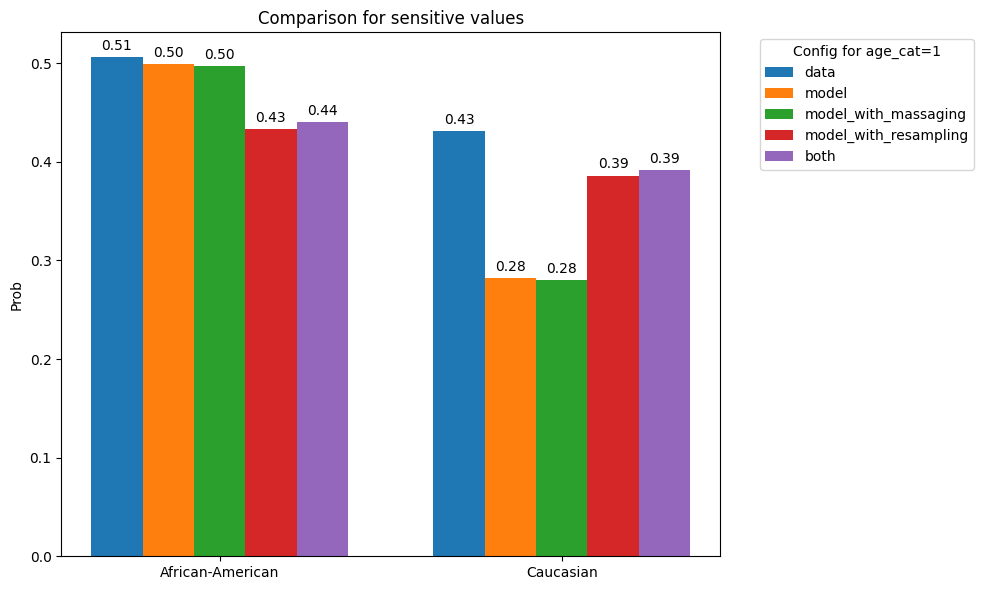

In [327]:
import matplotlib.pyplot as plt
import numpy as np

# Data
tasks = ['African-American', 'Caucasian']
categories = ['data', 'model', 'model_with_massaging', 'model_with_resampling', 'both']
values = {
    'African-American': [0.505925, 0.499088, 0.496809, 0.433455, 0.440292],
    'Caucasian': [0.431402, 0.282012, 0.279726, 0.385952, 0.391272]
}

# Plot settings
x = np.arange(len(tasks))  # label locations for tasks
width = 0.15  # bar width for each category

fig, ax = plt.subplots(figsize=(10, 6))

# Create bars for each category and task
for i, category in enumerate(categories):
    offsets = x + (i - 2) * width  # offsets for bars within each task group
    ax.bar(offsets, [values[task][i] for task in tasks], width, label=category)

# Add labels, title, and legend
ax.set_ylabel('Prob')
ax.set_title('Comparison for sensitive values')
ax.set_xticks(x)
ax.set_xticklabels(tasks)
ax.legend(title="Config for age_cat=1", bbox_to_anchor=(1.05, 1), loc='upper left')

# Annotate bars
for i, category in enumerate(categories):
    offsets = x + (i - 2) * width
    for j, offset in enumerate(offsets):
        value = values[tasks[j]][i]
        ax.annotate(f'{value:.2f}',
                    xy=(offset, value),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()


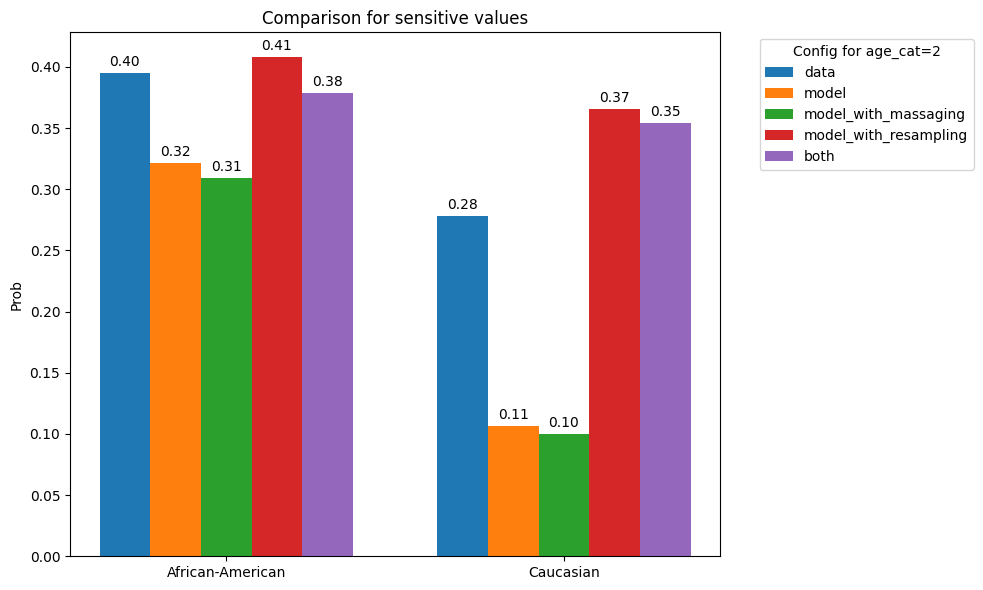

In [328]:
import matplotlib.pyplot as plt
import numpy as np

# Data
tasks = ['African-American', 'Caucasian']
categories = ['data', 'model', 'model_with_massaging', 'model_with_resampling', 'both']
values = {
    'African-American': [0.395189, 0.321306, 0.309278, 0.407834, 0.378819],
    'Caucasian': [0.277926, 0.106383, 0.099734, 0.365563, 0.353723]
}

# Plot settings
x = np.arange(len(tasks))  # label locations for tasks
width = 0.15  # bar width for each category

fig, ax = plt.subplots(figsize=(10, 6))

# Create bars for each category and task
for i, category in enumerate(categories):
    offsets = x + (i - 2) * width  # offsets for bars within each task group
    ax.bar(offsets, [values[task][i] for task in tasks], width, label=category)

# Add labels, title, and legend
ax.set_ylabel('Prob')
ax.set_title('Comparison for sensitive values')
ax.set_xticks(x)
ax.set_xticklabels(tasks)
ax.legend(title="Config for age_cat=2", bbox_to_anchor=(1.05, 1), loc='upper left')

# Annotate bars
for i, category in enumerate(categories):
    offsets = x + (i - 2) * width
    for j, offset in enumerate(offsets):
        value = values[tasks[j]][i]
        ax.annotate(f'{value:.2f}',
                    xy=(offset, value),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()
